## Calculate ZDR Bias From QVP

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as mdates
import os, glob
import pyart
import xarray as xr

# ****************************************************************************************

def retrieve_qvp(filename, flds = None):
    if flds == None:
        flds = ['PH','RH','CZ','DR']
    radar = pyart.io.read(filename)
    desired_angle = 9.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    #print(radar.fixed_angle['data'])
    #print(radar.elevation['data'][-1])
    qvp = {}
    for fld in flds:
        this_fld = radar.get_field(index, fld).mean(axis = 0)
        qvp.update({fld:this_fld})
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = pyart.core.transforms.antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                             radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    del radar
    return qvp

# ****************************************************************************************

def extract_height_data(ds, min_height, max_height):
    
    # Extract ZDR values in the region between min_height and max_height.
    
    height_data = ds['DR'].sel({'height': slice(min_height, max_height)})
    return height_data.values

# ****************************************************************************************

def extract_time_data(ds, min_time, max_time):
    
    # Extract ZDR values in the region between min_height and max_height.
    
    time_data = ds.sel({'time': slice(min_time, max_time)})
    return time.values

# ****************************************************************************************

def calculate_zdr_offset(zdr_values):
    
    # Calculate the ZDR calibration offset.
    mean_zdr = np.nanmean(zdr_values)
    
    # Subtract intrinsic value of ZDR in light rain (0.18 dB)
    offset = mean_zdr - 0.18
    return offset

# ****************************************************************************************

def apply_zdr_offset(zdr_values, offset):
    """
    Apply the ZDR calibration offset to the data.
    """
    calibrated_zdr = zdr_values + offset
    return calibrated_zdr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Read in a full day and create QVP dictionary

In [2]:
# KPOL test case
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/150310/'
# KDOX test case
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/KDOX/240830/'
# NPOL cases
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/231218/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240227/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240323/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240506/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240507/'
in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240605/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240607/'
wc = in_dir + '*.cf'
all_files = sorted(glob.glob(wc))

result = []
for file in all_files:
    field_names = ['PH','RH','CZ','DR']
    result.append(retrieve_qvp(file))

kpol_qvps = result

### Organize data into a time series

In [3]:
# Create an empty dictionary to be filled
kpol_time_series = {}

# Work out how many profiles
n_times = len(kpol_qvps)

# Loop over all fields 
for fld in ['PH','RH','CZ', 'DR']:
    # Create empty time series
    this_fld = np.zeros([n_times, len(kpol_qvps[0][fld])])
    
    # Create time array
    kpol_times = np.zeros(n_times)
    
    # Loop over all times
    for i in range(n_times):
        
        # Create a datetime object
        dateobj = num2date(kpol_qvps[i]['time']['data'][0], kpol_qvps[i]['time']['units'])
        
        # Append a numerical date using Matplotlib's time reference
        kpol_times[i] = mdates.date2num(dateobj)
        
        # Update the profile to the time series
        this_fld[i,:] = kpol_qvps[i][fld]
    
    # Append the time series to the dictionary
    kpol_time_series.update({fld: this_fld[kpol_times.argsort(), :]})
    
# Sort times    
kpol_times.sort()


### Plot CZ

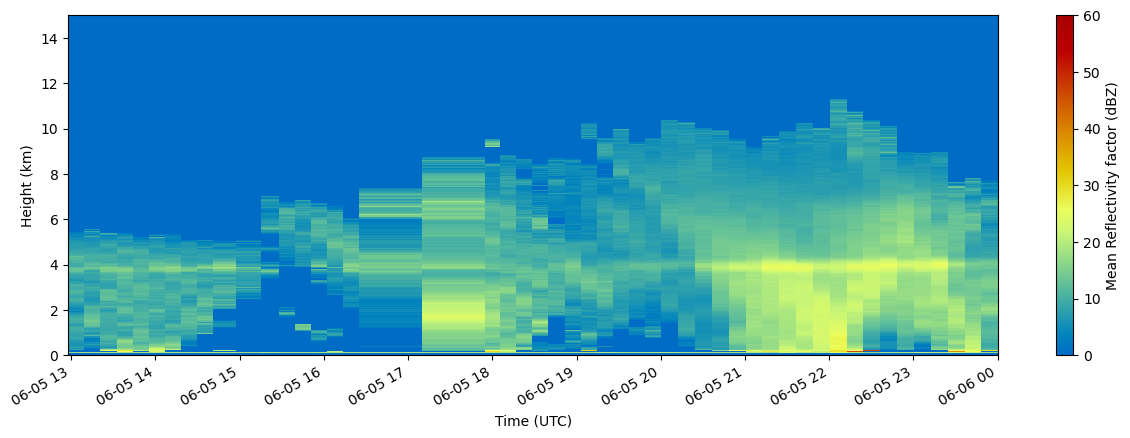

In [4]:
fig = plt.figure(figsize = [15,5])

pc = plt.pcolormesh(kpol_times, kpol_qvps[0]['height']/1000.0, 
                    kpol_time_series['CZ'].transpose(),
                    vmin = 0, vmax = 60, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

ax = plt.gca()
'''
ax.contourf(kpol_times, kpol_qvps[0]['height']/1000.0, 
            cz.transpose(),
            vmin = 0, vmax = 60, cmap=pyart.graph.cm.NWSRef)
'''
ax = plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,15])
cb = plt.colorbar()
cb.set_label('Mean Reflectivity factor (dBZ)')
plt.show()

### Plot ZDR

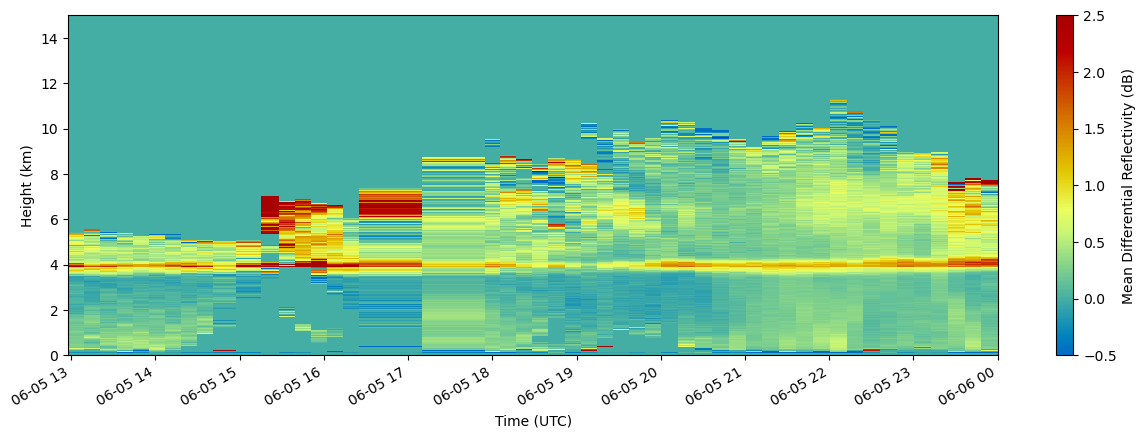

In [5]:
fig = plt.figure(figsize = [15,5])

pc = plt.pcolormesh(kpol_times, kpol_qvps[0]['height']/1000.0, 
                    kpol_time_series['DR'].transpose(),
                    vmin = -0.5, vmax = 2.5, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

ax = plt.gca()
'''
ax.contourf(kpol_times, kpol_qvps[0]['height']/1000.0, 
            dr.transpose(),
            vmin = -0.5, vmax = 2.5, cmap=pyart.graph.cm.Carbone42)
'''
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,15])
cb = plt.colorbar()
cb.set_label('Mean Differential Reflectivity (dB)')
plt.show()

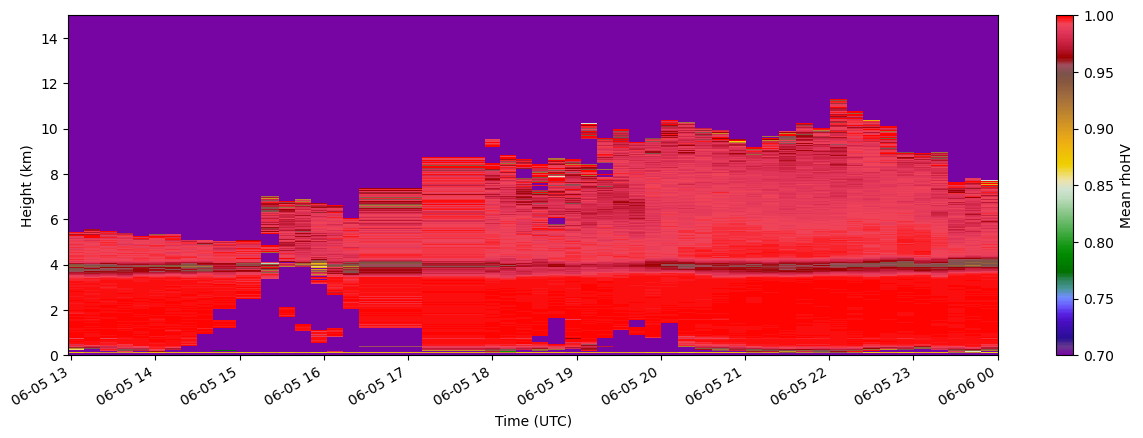

In [9]:
fig = plt.figure(figsize = [15,5])

pc = plt.pcolormesh(kpol_times, kpol_qvps[0]['height']/1000.0, 
                    kpol_time_series['RH'].transpose(),
                    vmin = 0.70, vmax = 1.0, cmap=pyart.graph.cm.Carbone42)

ax = plt.gca()
'''
ax.contourf(kpol_times, kpol_qvps[0]['height']/1000.0, 
            kpol_time_series['RH'].transpose(),
            vmin = 0.72, vmax = 1.0, cmap=pyart.graph.cm.Carbone42)
'''
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,15])
cb = plt.colorbar()
cb.set_label('Mean rhoHV')
plt.show()

### Convert dictionary to xarray Dataset

In [7]:
# Convert dictionary to xarray Dataset

ds = xr.Dataset(
    {
        "DR": (["time", "height"], kpol_time_series["DR"]),
        "CZ": (["time", "height"], kpol_time_series["CZ"]),
        "PH": (["time", "height"], kpol_time_series["PH"]),
        "RH": (["time", "height"], kpol_time_series["RH"]),
    },
    coords={
        "time": kpol_times,
        "height": kpol_qvps[0]['height']
    }
)

print(ds)

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 50, height: 1081)
Coordinates:
  * time     (time) float64 400B 1.988e+04 1.988e+04 ... 1.988e+04 1.988e+04
  * height   (height) float64 9kB 0.0 19.55 39.1 ... 2.214e+04 2.216e+04
Data variables:
    DR       (time, height) float64 432kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CZ       (time, height) float64 432kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PH       (time, height) float64 432kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    RH       (time, height) float64 432kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


In [8]:
# Obtain min and max height from plots above
#min_height = 2000
#max_height = 8000
min_height = 0
max_height = 3750

# Set data to nan outside Zh values 0 < Zh < 20 dBZ.
ds = ds.where((ds.CZ >= 0) & (ds.CZ <= 20), np.nan)

# Set data to nan when RH < 0.98.
ds = ds.where(ds.RH > 0.985, np.nan)

# Extract ZDR values within height range
zdr_values = extract_height_data(ds, min_height, max_height)

# Extract values within time range
#time_values = extract_time_data(zdr_values, min_time, max_time)

# Compute the calibration offset
offset = calculate_zdr_offset(zdr_values)
#intr = offset + 0.18
print(f"ZDR QVP offset: {offset:.2f} dB")
#print(f"ZDR QVP offset: {intr:.2f} dB")

ZDR QVP offset: -0.07 dB


In [ ]:
# Jun 7, 2024: BB offset 0.0 dB, QVP offset: 0.09 dB, Height 0-4.0km
# Jun 5, 2024: BB offset +0.08 dB, QVP offset: -0.07 dB, Height 0-3.75km
# May 7, 2024: BB offset +0.28 dB, QVP offset: 0.02 dB, Height 0-3.0km
# May 6, 2024: BB offset +0.26 dB, QVP offset: 0.22 dB, Height 0-3.0km
# Mar 23, 2024: BB offset -0.30 dB, QVP offset: -0.35 dB, Height 0-1.75km
# Feb 27, 2024: BB offset -0.17 dB, QVP offset: -0.22 dB, Height 0-2.0km
# Dec 18, 2023: BB offset -0.01 dB, QVP offset: -0.17 dB, Height 0-2.50km

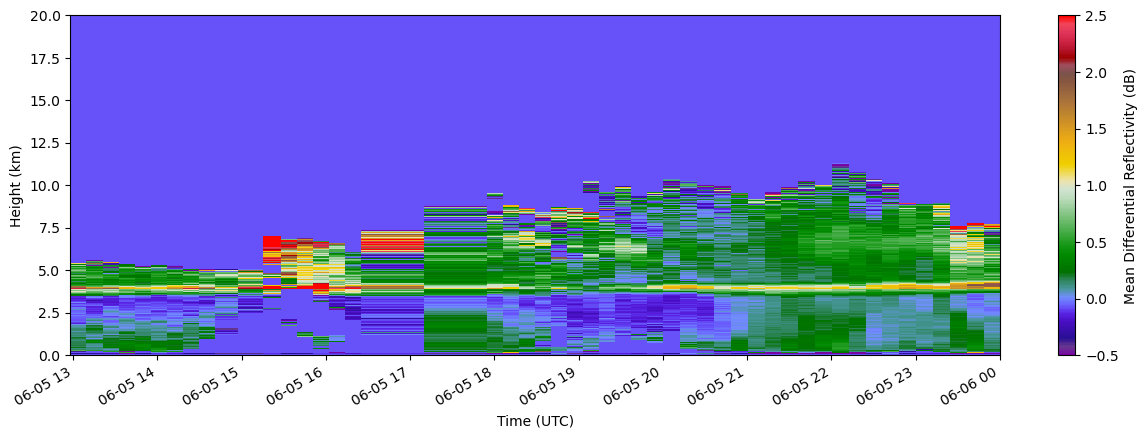

In [11]:
calibrated_zdr = apply_zdr_offset(kpol_time_series['DR'], offset)

fig = plt.figure(figsize = [15,5])
pc = plt.pcolormesh(kpol_times, kpol_qvps[0]['height']/1000.0, 
                    calibrated_zdr.transpose(),
                    vmin = -0.5, vmax = 2.5, cmap=pyart.graph.cm.Carbone42)

ax = plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,20])
cb = plt.colorbar()
cb.set_label('Mean Differential Reflectivity (dB)')
plt.show()